In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats
from math import sin, cos, sqrt, atan2, radians
from typing import List, Tuple, Any

from sklearn.cluster import MiniBatchKMeans

%matplotlib inline

### i. Creating the dataset
----

If you've run `make_sample_set.py` you should have a fairly decent sized csv file to use for analysis.
The `row_limit` variable will help you control the amount of data used if your machine can't handle the size of `sample_set.csv`.

The other CSV file, `capbs_stations.csv`, has latitude, longitude, and other features we'll use to enhance our exploratory data analysis.

In [2]:
seed = 33
row_limit = 300000
data_dir = '../data/'

rides_use_columns = [
    'Duration', 'Start date', 'End date', 'Start station', 'Start station number', 'End station number', 'Member type'
]
dataset = pd.DataFrame()
for file in os.listdir(os.path.join(data_dir, 'rides')):
    if file.startswith('sample_set'):
        print(f'Reading in {file}...')
        tmp = pd.read_csv(
            os.path.join(data_dir, 'rides', file), 
            nrows=row_limit, 
            usecols=rides_use_columns
        )
        dataset = pd.concat([dataset, tmp], sort=False, ignore_index=True)

dataset['Start station number'] = dataset['Start station number'].astype(int)
        
stations_use_columns = [
    'TERMINAL_NUMBER', 'LONGITUDE', 'LATITUDE', 'NUMBER_OF_EMPTY_DOCKS', 'NUMBER_OF_BIKES'
]
stations = pd.read_csv(
    os.path.join(data_dir, 'stations/capbs_stations.csv'),
    usecols=stations_use_columns
)

Reading in sample_set.csv...


In [3]:
print(f'Rides dataset (rows, columns): {dataset.shape}')


# Removed extremely long rides (greater than 1.5 hours) to help linear models
# dataset = dataset.loc[(dataset['Duration'] <= (60 * 60 * 1.5)), :]
# print(f'Cleaned Dataset (rows, columns): {dataset.shape}')

Rides dataset (rows, columns): (300000, 7)


In [4]:
print(f'Stations information (rows, columns): {stations.shape}')
stations.head(3)

Stations information (rows, columns): (571, 5)


,TERMINAL_NUMBER,LATITUDE,LONGITUDE,NUMBER_OF_BIKES,NUMBER_OF_EMPTY_DOCKS
0,32017,39.083673,-77.149162,7,8
1,32018,39.123513,-77.157410,7,7
2,32019,38.990249,-77.029350,2,13


The columns in the stations dataframe are renamed to look nicer and help make joining the two datasets easier.

In [5]:
stations.loc[:,'station_total_bikes'] = stations.loc[:,'NUMBER_OF_BIKES'] + stations.loc[:,'NUMBER_OF_EMPTY_DOCKS']
stations_start = stations.loc[:, ['station_total_bikes', 'LATITUDE', 'LONGITUDE', 'TERMINAL_NUMBER']]
stations_end = stations.loc[:, ['LATITUDE', 'LONGITUDE', 'TERMINAL_NUMBER']]

stations_start.columns = ['station_total_bikes', 'start_station_lat', 'start_station_long', 'Start station number']
stations_end.columns = ['end_station_lat', 'end_station_long', 'End station number']

stations_start.head(3)

,station_total_bikes,start_station_lat,start_station_long,Start station number
0,15,39.083673,-77.149162,32017
1,14,39.123513,-77.157410,32018
2,15,38.990249,-77.029350,32019



Now that the datasets are how we want them to look, we can join them. We'll be joining on 'Start station number'

FYI - A few stations are no longer in service. (i.e. They existed in the `sample_set.csv`, but not in the `capbs_stations.csv`. I looked up the coordinates in Google Maps and those stations are no longer there. So, they are removed to make things easier.)


In [6]:
dataset = dataset.merge(stations_start, on='Start station number', how='left', sort=False)
dataset = dataset.merge(stations_end, on='End station number', how='left', sort=False)

# Stations that are no longer in service
dataset = dataset.loc[~(dataset['Start station number'] == 31008) &
                       ~(dataset['Start station number'] == 32051) &
                       ~(dataset['Start station number'] == 32034), :]

dataset = dataset.loc[~(dataset['End station number'] == 31008) &
                       ~(dataset['End station number'] == 32051) &
                       ~(dataset['End station number'] == 32034), :]

# Woo! We made the dataset!
dataset.head(3)

,Duration,Start date,End date,Start station number,Start station,End station number,Member type,station_total_bikes,start_station_lat,start_station_long,end_station_lat,end_station_long
0,1012,2010-09-20 11:27:04,2010-09-20 11:43:56,31208,M St & New Jersey Ave SE,31108,Member,16.0,38.87630,-77.003700,38.87670,-77.017800
1,2690,2010-09-20 12:05:37,2010-09-20 12:50:27,31600,5th & K St NW,31100,Member,18.0,38.90304,-77.019027,38.90030,-77.042900
2,1413,2010-09-20 12:10:43,2010-09-20 12:34:17,31100,19th St & Pennsylvania Ave NW,31201,Member,15.0,38.90030,-77.042900,38.90985,-77.034438


## i. Exploratory Data Analysis

---

Now that the dataset has what we want, let's explore it!

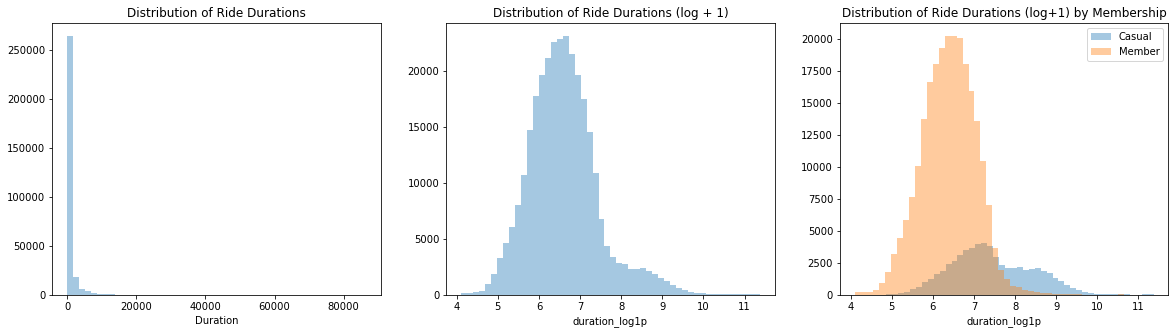

In [7]:
# Univariate analysis on target feature: "Duration"
plt.figure(figsize=(20,5));

plt.subplot(1,3,1);
sns.distplot(dataset['Duration'], bins=50, kde=False);
plt.title('Distribution of Ride Durations');

## heavily skewed target variable will be log1p transformed
dataset['duration_log1p'] = np.log1p(dataset['Duration'])

plt.subplot(1,3,2);
sns.distplot(dataset['duration_log1p'], bins=50, kde=False);
plt.title('Distribution of Ride Durations (log + 1)');

plt.subplot(1,3,3);
sns.distplot(dataset.loc[dataset['Member type'] == 'Casual', 'duration_log1p'], bins=50, label='Casual', kde=False);
sns.distplot(dataset.loc[dataset['Member type'] == 'Member', 'duration_log1p'], bins=50, label='Member', kde=False);
plt.legend();
plt.title('Distribution of Ride Durations (log+1) by Membership');

In [8]:
# The distribution above shows that are some very long rides skewing the data...
longest_ride = dataset['Duration'].max()
print(f'The longest ride was {round(longest_ride / 60, 2)} minutes or {round(longest_ride / 60 / 60, 2)} hours!')

The longest ride was 1439.25 minutes or 23.99 hours!



Outliers like these will impact a linear model's performance. This is definitely something that will need to be addressed,
however, it's not fair to just throw away or discard valid data. For example, let's say we were using a dataset 
of pro football players with features "weight" and "height". If a player in the dataset had a weight of something
like 45 lbs or a height of 2'7 then discarding that data would be justified as these values are not possible  
for an adult let alone a professional athlete. In our situation, however, it is possible that the rider may
have checked out a bike, rode it home, parked it outside their home or apartment and then returned it the next day.


##### Time features and Member type
The next few graphs will take a look at how time features relate to the ride duration. Also since we have a categorical field, "Member type", we'll compare those categories as well.

In [9]:
# Convert Start date and End date to "datetime" type
dataset['Start date'] = pd.to_datetime(dataset['Start date'])
dataset['End date'] = pd.to_datetime(dataset['End date'])

# Create separate "time" features
dataset['week_of_year'] = dataset['Start date'].apply(lambda x: x.weekofyear)
dataset['day_of_week'] = dataset['Start date'].apply(lambda x: x.dayofweek)
dataset['month'] = dataset['Start date'].apply(lambda x: x.month)
dataset['minute'] = dataset['Start date'].apply(lambda x: x.minute)
dataset['hour'] = dataset['Start date'].apply(lambda x: x.hour)

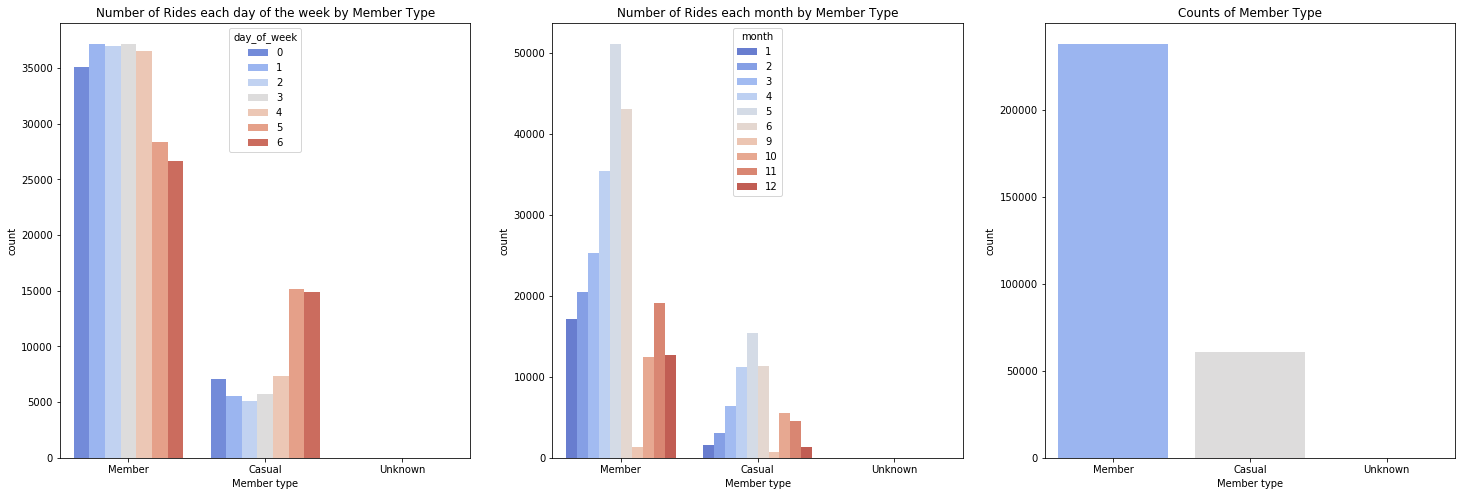

In [10]:
plt.figure(figsize=(25,8));

plt.subplot(1,3,1);
sns.countplot(x='Member type', hue='day_of_week', data=dataset, palette='coolwarm');
plt.title('Number of Rides each day of the week by Member Type');

plt.subplot(1,3,2);
sns.countplot(x='Member type', hue='month', data=dataset, palette='coolwarm');
plt.title('Number of Rides each month by Member Type');

plt.subplot(1,3,3);
sns.countplot(x='Member type', data=dataset, palette='coolwarm');
plt.title('Counts of Member Type');

Casual rides happen heavily on the weekends, whereas, riders using the Members plan tend to ride more during the week. Perhaps, buying the membership for the week when things aren't crowded makes more sense than a Casual pass? And/or buying a Casual pass on the weekend makes more sense than a Member pass because things are crowded or the individuals' are only planning on riding for the day?

Not sure what Member type "Unknown" is... I will probably remove it.

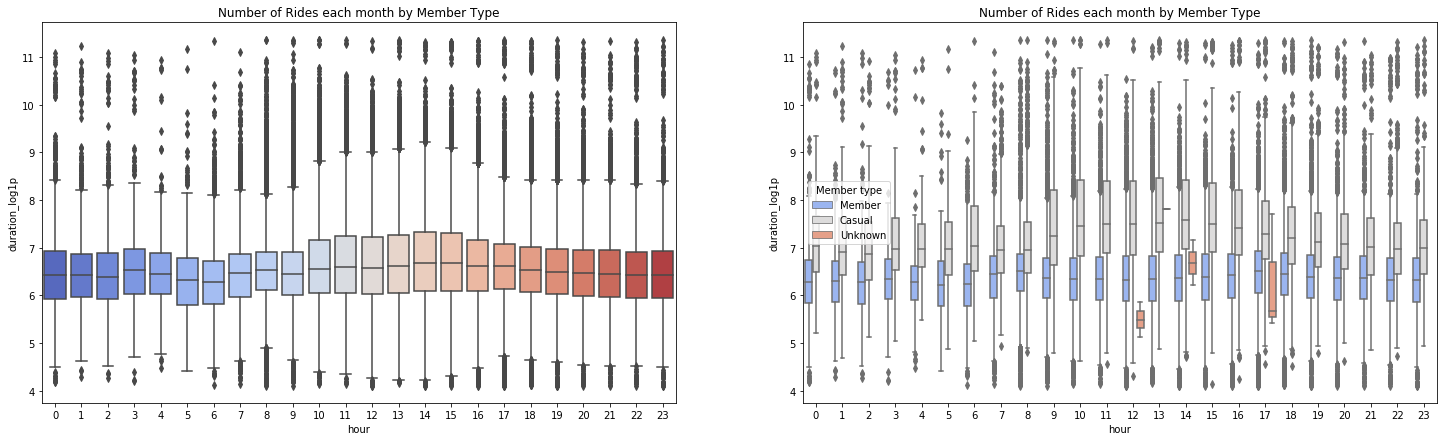

In [11]:
plt.figure(figsize=(25,7));

plt.subplot(1,2,1);
sns.boxplot(x='hour', y='duration_log1p', data=dataset, palette='coolwarm');
plt.title('Number of Rides each month by Member Type');

plt.subplot(1,2,2);
sns.boxplot(x='hour', y='duration_log1p', hue='Member type', data=dataset, palette='coolwarm');
plt.title('Number of Rides each month by Member Type');

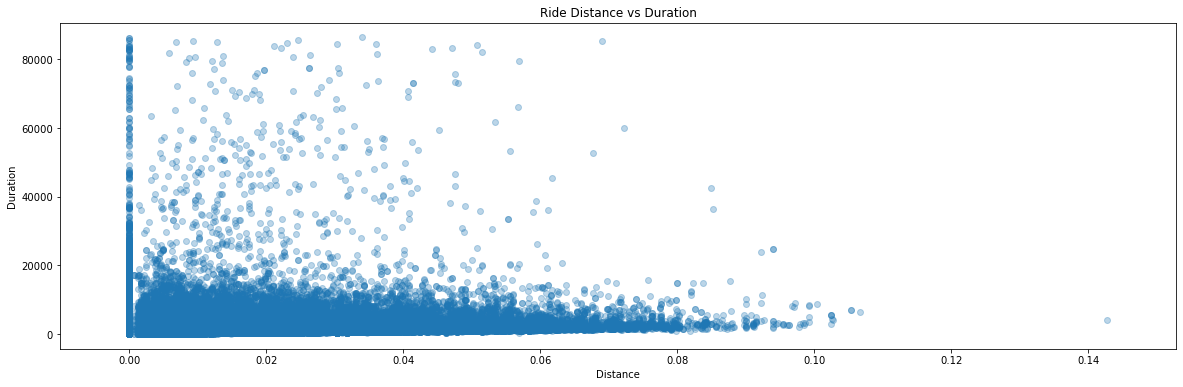

In [12]:
dataset['euclidian_distance'] = np.sqrt((dataset['start_station_lat'] - dataset['end_station_lat'])**2 + 
                                       (dataset['start_station_long'] - dataset['end_station_long'])**2)

plt.figure(figsize=(20,6));
plt.scatter(x='euclidian_distance', y='Duration', data=dataset, alpha=0.3);
plt.title('Ride Distance vs Duration');
plt.xlabel('Distance');
plt.ylabel('Duration');

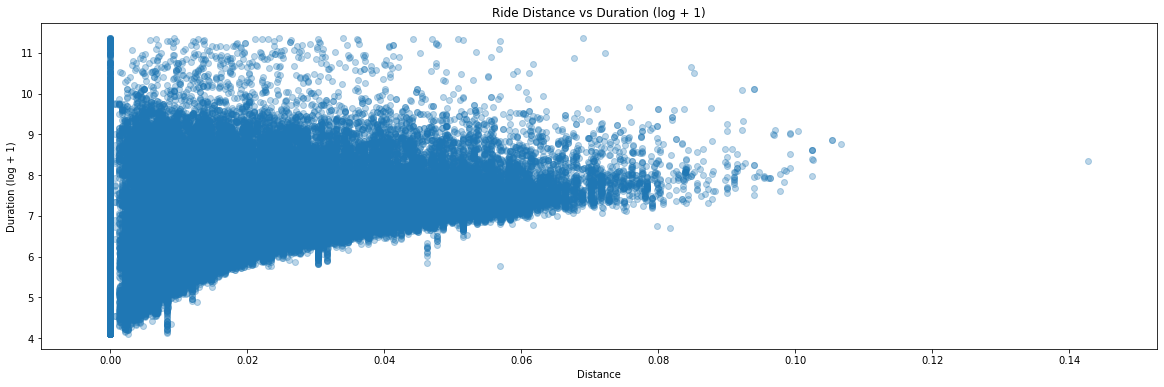

In [13]:
plt.figure(figsize=(20,6));
plt.scatter(x='euclidian_distance', y='duration_log1p', data=dataset, alpha=0.3);
plt.title('Ride Distance vs Duration (log + 1)');
plt.xlabel('Distance');
plt.ylabel('Duration (log + 1)');

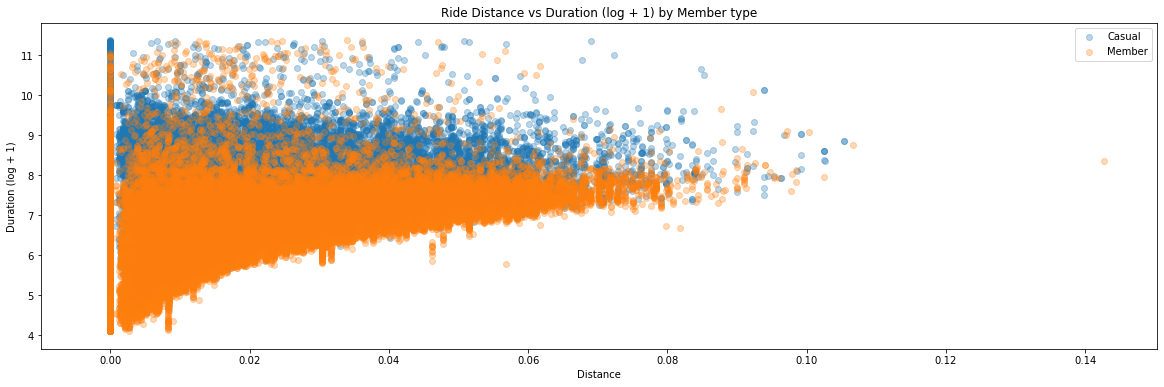

In [14]:
plt.figure(figsize=(20,6));
plt.scatter(
    x='euclidian_distance', 
    y='duration_log1p', 
    data=dataset.loc[dataset['Member type'] == 'Casual',:], 
    alpha=0.3,
    label='Casual'
);
plt.scatter(
    x='euclidian_distance', 
    y='duration_log1p', 
    data=dataset.loc[dataset['Member type'] == 'Member',:], 
    alpha=0.3,
    label='Member'
);

plt.title('Ride Distance vs Duration (log + 1) by Member type');
plt.xlabel('Distance');
plt.ylabel('Duration (log + 1)');
plt.legend();

As expected with bike sharing, a longer ride duration doesn't necessarily mean a longer ride distance wise, because
unlike an uber ride, bike riders can always return to the station where they started as one "trip". 

Also, something interesting to note: "Casual" riders are taking longer rides than "Member" riders.

In [15]:
mems_same_station = dataset.loc[(dataset['Member type'] == 'Member') & (dataset['Start station number'] == dataset['End station number']), :].shape[0]
cas_same_station = dataset.loc[(dataset['Member type'] == 'Casual') & (dataset['Start station number'] == dataset['End station number']), :].shape[0]

print(f'[{mems_same_station}] Member riders started and ended at the same station.')
print(f'[{cas_same_station}] Casual riders started and ended at the same station.')

[5584] Member riders started and ended at the same station.
[9551] Casual riders started and ended at the same station.


Even though in total there are almost 4x as many "Member" riders than "Casual" riders, the "Casual" riders overwhelmingly tend to start and stop at the same station number. This sounds reasonable - maybe "Casual" riders are less familiar with the area? parked their car nearby? have a predetermined loop to ride before starting?

##### What is a Typical Ride with Capital BikeShare?

So far we've seen that Casual and Member riders are using bike sharing differently, but what else can the dataset tell us? Let's see if we can identify any deeper differences or similiarities there are between rides. We'll attempt to segment all rides into 50 "Typical" rides.

First, check out `folium`! It's an awesome library for maps and geographical data like coordinates! I use to plot all the "stations" in the dataset below.

In [16]:
import folium

bike_map = folium.Map(location=[38.892239, -77.036898], tiles='OpenStreetMap', zoom_start=12)
for index, row in stations_start.iterrows():
    folium.CircleMarker(
        [row['start_station_lat'], row['start_station_long']],
        radius=3,
        tooltip=int(row['Start station number']),
        color='#007bff',
        popup=str(row['start_station_lat'])+','+str(row['start_station_long']),
        fill_color='#FD8A6C'
        ).add_to(bike_map)
    
bike_map

In [17]:
# You can save a map as HTML! ... A little foreshadowing for PART II. of the repository.
# bike_map.save('bike_map.html')

In [ ]:
ride_attr_columns = ['start_station_lat', 'start_station_long', 'end_station_lat', 'end_station_long', 'Duration']
ride_attributes = dataset.loc[:, ride_attr_columns].values

ride_means = ride_attributes.mean(axis=0)
ride_std = ride_attributes.std(axis=0)
ride_attributes = stats.zscore(ride_attributes, axis=0)

num_clusters = 100
ride_clusters = MiniBatchKMeans(n_clusters=num_clusters, batch_size=200000, n_init=100, random_state=seed)
cluster_inds = ride_clusters.fit_predict(ride_attributes)

In [ ]:
cluster_total_counts, _ = np.histogram(cluster_inds, bins=num_clusters)
sorted_cluster_inds = np.flipud(np.argsort(cluster_total_counts))

In [ ]:
plt.figure(figsize=(12,4)); 
plt.title('Cluster Histogram of all rides');
plt.bar(range(1,num_clusters+1), cluster_total_counts[sorted_cluster_inds]);
plt.ylabel('Frequency [counts]'); plt.xlabel('Cluster index (sorted by cluster frequency)');
plt.xlim(0,num_clusters+1);

FYI - I randomly switch maps and stop using `folium` here - that's because I couldn't find an easy way to add arrows. Sorry!

In [ ]:
template_rides = ride_clusters.cluster_centers_ * np.tile(ride_std,(num_clusters,1)) + np.tile(ride_means,(num_clusters,1))

src_coords = template_rides[:, :2]
dst_coords = template_rides[:, 2:4]

station_num_coords = dataset.groupby('Start station number')[['start_station_lat', 'start_station_long']].first()

BBox = (
    stations_start.start_station_long.min(),
    stations_start.start_station_long.max(),      
    stations_start.start_station_lat.min(),
    stations_start.start_station_lat.max()
)

cbdc = plt.imread('../data/img/area.png')

fig, ax = plt.subplots(figsize=(18, 13));
ax.scatter(x=stations_start.start_station_long, y=stations_start.start_station_lat, c='#007bff', zorder=1, alpha=0.3, s=25)
ax.scatter(src_coords[:,1], src_coords[:,0], zorder=1, c='m', s=100, alpha=0.6)
ax.scatter(dst_coords[:,1], dst_coords[:,0], c='r', s=100, alpha=0.6)
ax.set_title(f'Modelling "{num_clusters}" Typical Rides with Capital BikeShare')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(cbdc, zorder=0, extent=BBox, aspect='equal');

for i in range(len(src_coords[:,0])):
    plt.arrow(
        src_coords[:,1][i], 
        src_coords[:,0][i], 
        dst_coords[:,1][i]-src_coords[:,1][i], 
        dst_coords[:,0][i]-src_coords[:,0][i], 
        edgecolor='c', 
        facecolor='c', 
        width=0.0005, 
        alpha=0.6, 
        head_width=0.001, 
        head_length=0.003, 
        length_includes_head=True
    )

As expected, a majority of rides end within downtown DC where most stations (and the excitement!) are located. 

A few rides that stuck out to me:

- The college campuses American Univserity and Georgetown also have a well defined arrows into and out of downtown. Students probably heading to work, class, or where all the action is happening.


- The route between Alexandria and just below DC seems like quite a distance. Sure enough, after a quick Google search I found - https://www.mountvernon.org/plan-your-visit/directions-parking-transportation/visit-mount-vernon-by-bike/ - There's an 18 mile, paved bike route from DC to George Washington's Mount Vernon estate in Alexendria. Very cool!

One final observation, stations like those in Silver Spring and Rockville seem almost "cutoff" from the other stations closer to DC. I didn't really investigate single bike usage, but I'd bet that bikes in these areas almost exclusively stay in these areas for their lifetime.

In [ ]:
### more to come